# HW3(Assignment#3) - Breast Ultrasound Images Dataset에 U-net 적용
- 유방함 초음파 이미지 데이터셋에 대한 U-net 적용 모델 개발
- Author: 김성현(SeongHyun-Kim)
- Envs: Kaggle notebook
- Dataset: breast Ultrasound Images Dataset
- Affiliation(belong): 상명대학교 서울캠퍼스, 휴먼지능정보공학전공
- Student number: 201910783(Senior grade)

---
---

#### 유방암 초음파 데이터셋은 다른 데이터셋들과 다르게, 양성종양, 악성종양, 정상 3개지로 나뉘어져 있기 때문에, 이를 합쳐줘야지 학습을 시킬 수 있을 것으로 생각된다.

---
---
#### 1. U-Net을 이용한 유방암 병변 분할
#### 2. 모델 평가 (dice Score 혹은 IoU 중 택 1)
#### 3. 원본, Ground Truth 마스크, 모델 분할 결과 예시 (1건 이상) 출력

---
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from cv2 import imread,imshow,resize

import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import pathlib
from keras.preprocessing.image import img_to_array
import cv2
from PIL import Image

2024-05-26 13:04:09.692979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 13:04:09.693086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 13:04:09.862695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
paths = glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*')

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [5]:
sorted(glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/*'))[4:7]

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png']

In [6]:
# class합쳐서 하나의 데이터셋으로 만들어버리기.
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0   # additional variable to identify images consisting of 2 or more masks
    
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask
                    
                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [7]:
size = 128   # image size: 128x128
X, y = load_data('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*', size)

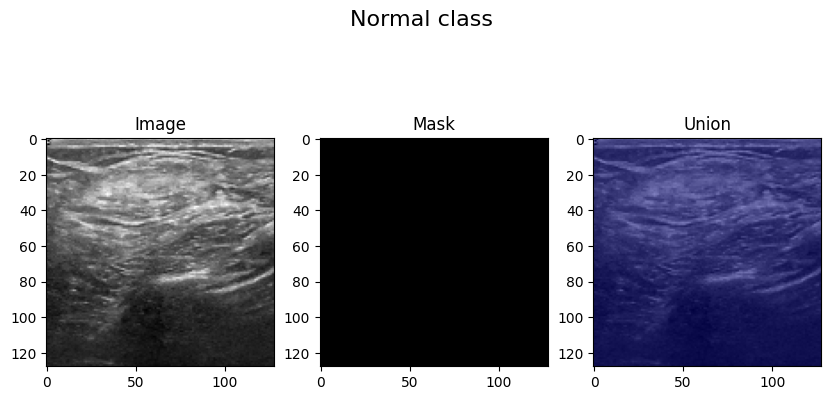

In [8]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

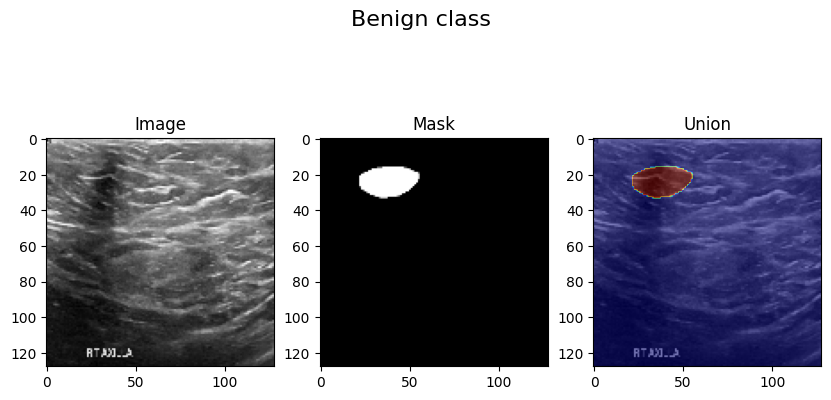

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

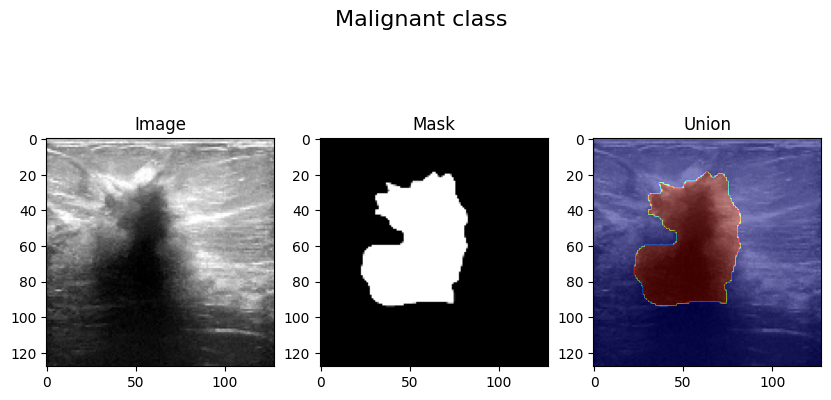

In [10]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

In [11]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


In [12]:
from glob import glob
from cv2 import imread,imshow,resize

import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


In [14]:
from keras.models import Model, load_model
from keras.layers import Input
# from keras.layers.core import Dropout, Lambda
from keras.layers import Dropout, Lambda
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import Concatenate

import tensorflow as tf

In [15]:
inputs = Input(shape=(128, 128, 1))

# s = layers.Lambda(lambda x:x/255)(inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
# c1 = layers.BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
# c1 = layers.BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
# c2 = layers.BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
# c2 = layers.BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
# c3 = layers.BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
# c3 = layers.BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
# c4 = layers.BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
# c4 = layers.BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 =Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ dropout_5[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 학습(training) 진행.
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping

earlystopper = EarlyStopping(patience=5, verbose=1)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

callbacks_list = [rlr_cb, ely_cb]

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=5, epochs=50, callbacks=callbacks_list)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30, callbacks=callbacks_list)

Epoch 1/30
 1/19 ━━━━━━━━━━━━━━━━━━━━ 13:32 45s/step - accuracy: 0.1966 - loss: 0.9545

I0000 00:00:1716728902.326589     278 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6555 - loss: 0.6000 - val_accuracy: 0.8947 - val_loss: 0.3584 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9104 - loss: 0.3288 - val_accuracy: 0.8947 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9011 - loss: 0.2902 - val_accuracy: 0.8947 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9125 - loss: 0.2294 - val_accuracy: 0.8947 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9044 - loss: 0.2308 - val_accuracy: 0.8947 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9061 - loss: 0.2239 - val_accuracy: 0.8977 - val_loss: 0.2776 - learning_rate: 0.0010
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9166 - loss: 0.2204 - val_accuracy: 0.909

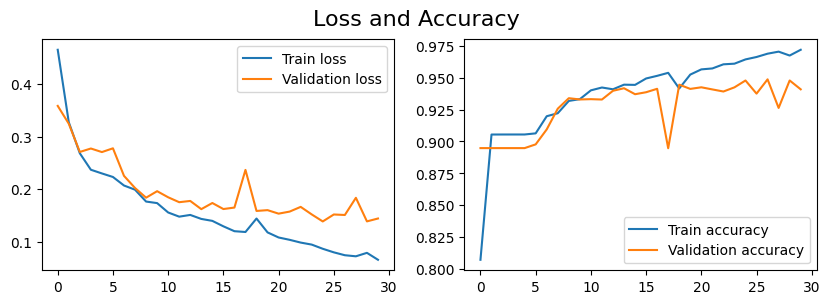

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

#### 모델 평가: IoU 평가기법 사용
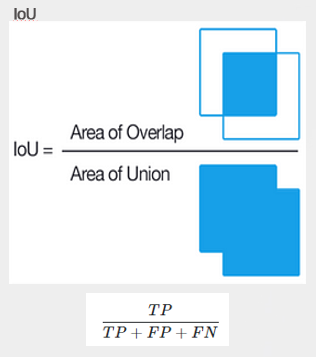

In [21]:
# Metrics
from tensorflow.keras.metrics import *

print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.75980306
Precision Score = 0.783
Recall Score = 0.698
F1 Score = 0.738


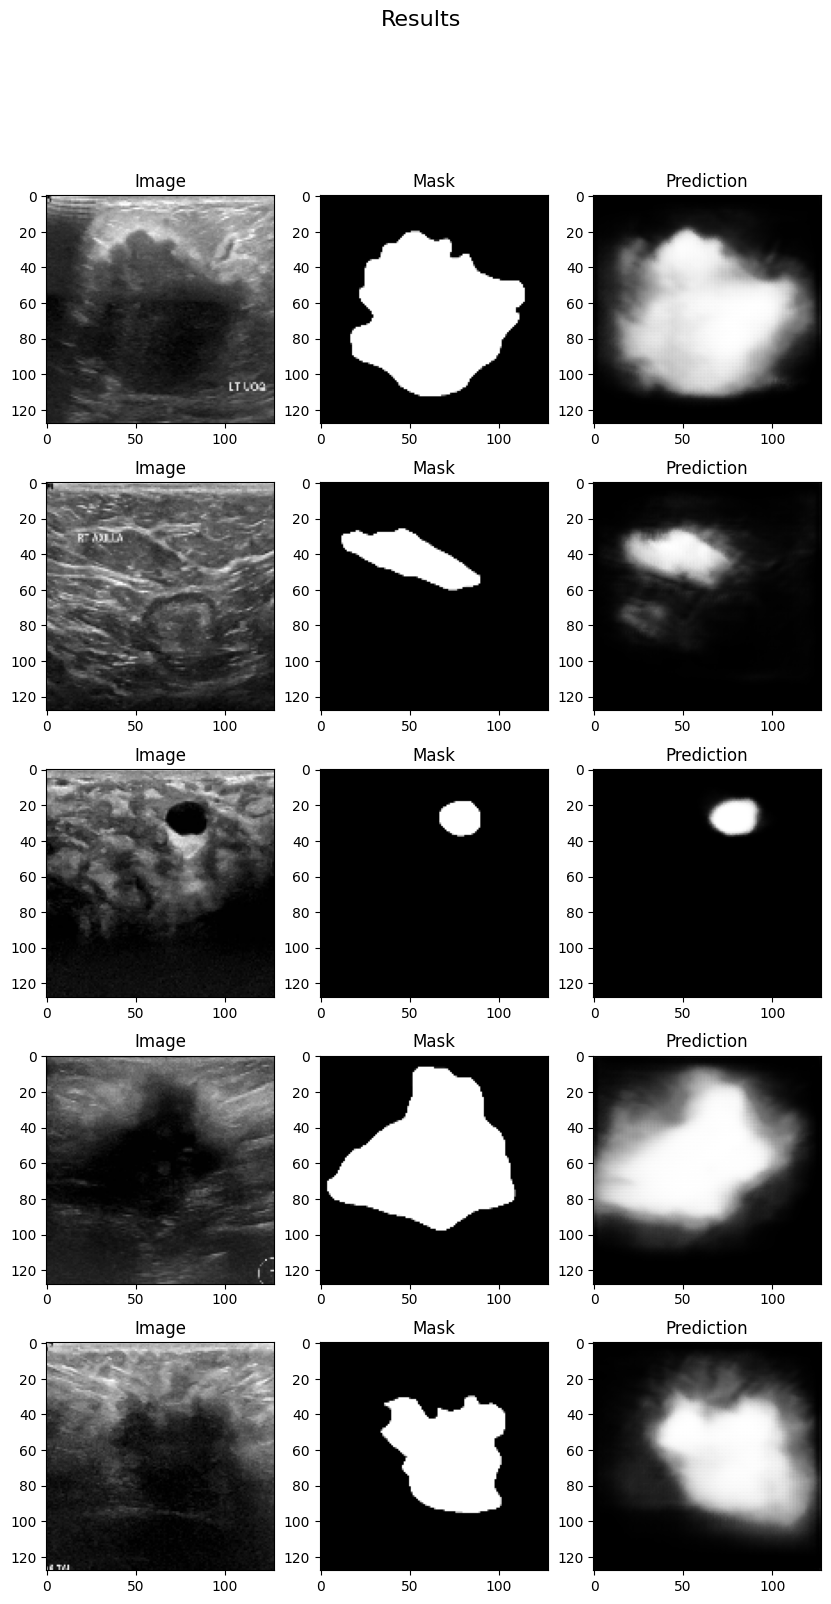

In [22]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

#### IoU 및 모델 분할 결과 성능이 낮은 요인으로는 데이터셋 전처리 과정에서 부족한 점이 있기 때문인 것으로 사료된다. kaggle의 draft session에서 주어지는 RAM 용량으로는 현재 불균형을 이루고 있는 각 class별 데이터셋들의 균형을 맞추기가 쉽지 않지만, 성능을 개선시키기 위해서는 이를 시도하는 방법 또한 가치가 있을 것으로 사료된다.